#  **Testing Gaussian EP on a given RBM**


In [1]:
using Pkg
using Plots
using Revise
using DelimitedFiles

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/an-na/.julia/packages/Revise/9lZUE/src/packagedef.jl:1369


In [2]:
include("../src/GaussianEP.jl")
include("../Sampling/Sampling.jl")
#Pkg.activate("/Users/luca/repos/GaussianEP/")
#using GaussianEP

Main.Sampling

In [ ]:
# Number of visible and hidden units, Gaussian weigths
N = 12
M = 4
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

# (Pv, Ph) = (Gaussian - Gaussian) priors

In [ ]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for i = 1:M];
P0 = vcat(Pv,Ph);

In [ ]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 100);

In [ ]:
using Plots

Σan = GaussianEP.compute_analytic(w,Pv,Ph)
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
Plots.plot(p1,p2)

# (Pv, Ph) = (Binary - Gaussian) priors

In [ ]:
x0v = 0.0; x1v = 1.0; ρ = 0.9;
μh = 0.5; βh = 3.0; 

Pv = [GaussianEP.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [GaussianEP.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0 = vcat(Pv,Ph);

In [ ]:
out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-7, maxiter=100000);
cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

In [ ]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, Pv, Ph);

In [ ]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [ ]:
Pv = [Sampling.BinaryPrior(x0v, x1v, ρ) for i = 1:N]
Ph = [Sampling.GaussianPrior(μh, βh, 0.0) for j = 1:M]
P0mc = vcat(Pv,Ph);

In [ ]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.005:0.2)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 0.05
nblocks = 22
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:
# Sampling using MCMC

Nconf = 10^6
Twait = 10^7
mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out);

In [ ]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [3]:

# Number of visible and hidden units, Gaussian weigths
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 2.0
μv = 0.0; βv = 1000.0; # βv needs to be large


In [4]:
γ_start = 50.0
γ_final = γ
N_iter = 10^2
step = (γ_start - γ_final) / N_iter

γiter = γ_start
init_state = nothing

Pv = [GaussianEP.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [GaussianEP.ReLUPrior(γiter,0.0) for j = 1:M ]
P0 = vcat(Pv,Ph)
out = nothing
for i=1:N_iter+1
    if mod(i,10) == 0
        println("γ: ", γiter)
    end
    Ph .= [GaussianEP.ReLUPrior(γiter,0.0) for j = 1:M ]
    P0 .= vcat(Pv,Ph)
    if i==1
        out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-8)
    else
        out = GaussianEP.expectation_propagation(H, P0; state = init_state, epsconv = 1e-8)
    end

    γiter -= step
    init_state = out.state
end

println(γ, " ?= ", γiter+step )

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end

it: 100 Δav: 3.76921465428115e-8
γ: 45.68000000000003
γ: 40.88000000000006
γ: 36.08000000000009
γ: 31.280000000000115
γ: 26.48000000000011
γ: 21.680000000000106
γ: 16.880000000000102
γ: 12.080000000000098
γ: 7.2800000000000935
γ: 2.480000000000091
2.0 ?= 2.000000000000091


In [5]:
Pv = [Sampling.GaussianPrior(μv, βv, 0.0) for i = 1:N];
Ph = [Sampling.ReLUPrior(γ,0.0) for j = 1:M ]
P0mc = vcat(Pv,Ph);

In [ ]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.05:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:

# Get thermalization time

Δ = 0.1
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [6]:
# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.1
Nconf = 5 * 10^5
Twait = 10^5

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [7]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out);

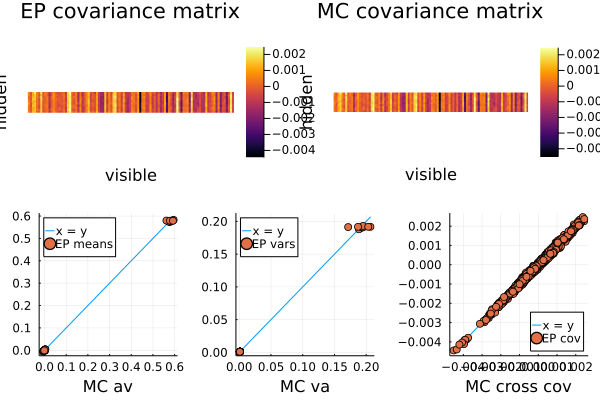

In [8]:

p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (SpikeAndSlab, ReLu) priors

In [53]:

# Number of visible and hidden units, Gaussian weigths
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 10.0
ρ = 0.1
λ = 510.0 # Big λ !
Pv = [GaussianEP.SpikeSlabPrior(ρ, λ) for i = 1:N]
Ph = [GaussianEP.ReLUPrior(γ, 0.0) for i = 1:M]
P0 = vcat(Pv, Ph);

In [54]:
γ_start = 500.0
γ_final = γ
N_iter = 100
step = (γ_start - γ_final) / N_iter


init_state = nothing
out = nothing
γiter = γ_start

for i=1:N_iter+1
    if mod(i,10) == 0
        println("γ: ", γiter)
    end
    Ph .= [GaussianEP.ReLUPrior(γiter,0.0) for j = 1:M ]
    P0 .= vcat(Pv,Ph)
    if i==1
        out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-7, nprint=500)
    else
        out = GaussianEP.expectation_propagation(H, P0; state = init_state, epsconv = 1e-7, nprint = 500)
    end

    γiter -= step
    init_state = out.state
end

println(γ, " ?= ", γiter+step )

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
end


γ: 455.9000000000002
γ: 406.90000000000043
γ: 357.90000000000066
γ: 308.9000000000009
γ: 259.9000000000011
γ: 210.90000000000106
γ: 161.900000000001
γ: 112.90000000000094
γ: 63.900000000000894
γ: 14.900000000000906
10.0 ?= 10.000000000000906


In [ ]:

Pv = [Sampling.SpikeSlabPrior(ρ, λ) for i = 1:N]
Ph = [Sampling.ReLUPrior(γ,0.0) for j = 1:M ]
P0mc = vcat(Pv,Ph);

In [ ]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.05:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:

# Get thermalization time

Δ = 0.1
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:

# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.1
Nconf = 5 * 10^5
Twait = 10^5

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:

# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out);

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)